In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import Adam

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


# 1. Import the data

In [56]:
train = pd.read_csv("/kaggle/input/facial-keypoints-detection/training.zip")

# 2. Preprocessing the data

We will separate the features from the labels first.

In [57]:
x = train['Image']
Y = train.drop(['Image'], axis=1)

Then we need to split the train data from the validation data so we don't have data leakage.

In [58]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_Y, val_Y = train_test_split(x, Y, test_size=0.2)

As we see here we have null values in most of our columns so we need to preprocess that somehow

In [59]:
print(train_Y.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             11
right_eye_center_y             11
left_eye_inner_corner_x      3818
left_eye_inner_corner_y      3818
left_eye_outer_corner_x      3821
left_eye_outer_corner_y      3821
right_eye_inner_corner_x     3819
right_eye_inner_corner_y     3819
right_eye_outer_corner_x     3819
right_eye_outer_corner_y     3819
left_eyebrow_inner_end_x     3817
left_eyebrow_inner_end_y     3817
left_eyebrow_outer_end_x     3855
left_eyebrow_outer_end_y     3855
right_eyebrow_inner_end_x    3816
right_eyebrow_inner_end_y    3816
right_eyebrow_outer_end_x    3849
right_eyebrow_outer_end_y    3849
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          3818
mouth_left_corner_y          3818
mouth_right_corner_x         3818
mouth_right_corner_y         3818
mouth_center_top_lip_x       3814
mouth_center_top_lip_y       3814
mouth_center_bottom_lip_x      30
mouth_center_b

We impute mean values of positions for missing values of positions of eyebros, lips... on the images.

In [61]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()

train_Y = pd.DataFrame(imputer.fit_transform(train_Y))
val_Y = pd.DataFrame(imputer.fit_transform(val_Y))

We're gonna pack our pictures into an array of arrays which are all size 96x96, because the pictures are of that resolution.

In [62]:
reshaped_train_x = []
reshaped_val_x = []

for entry in train_x:
    reshaped_entry = list(map(int, entry.split()))
    #reshaped_entry = np.array(reshaped_entry).reshape(96, 96, 1)
    reshaped_train_x.append(reshaped_entry)
    
for entry in val_x:
    reshaped_entry = list(map(int, entry.split()))
    #reshaped_entry = np.array(reshaped_entry).reshape(96, 96, 1)
    reshaped_val_x.append(reshaped_entry)

In [63]:
reshaped_train_x = pd.DataFrame(reshaped_train_x)
reshaped_val_x = pd.DataFrame(reshaped_val_x)

In [69]:
print(reshaped_train_x.shape)
print(reshaped_val_x.shape)

(5639, 96, 96, 1)
(1410, 96, 96, 1)


# 3. Defining the model

In [70]:
model = Sequential()

model.add(Lambda(lambda x: x/255.0, input_shape=(96, 96, 1)))
model.add(Conv2D(64, 5, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(128, 4, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(512, 2, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))

optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [71]:
history = model.fit(
    x=reshaped_train_x,
    y=train_Y,
    batch_size=128,
    epochs=10,
    validation_data=(reshaped_val_x, val_Y)
)

Epoch 1/10
45/45 [==============================] - 216s 5s/step - loss: 1310.3098 - accuracy: 0.0812 - val_loss: 306.7982 - val_accuracy: 0.0050
Epoch 2/10
45/45 [==============================] - 215s 5s/step - loss: 455.1799 - accuracy: 0.1777 - val_loss: 22.6630 - val_accuracy: 0.5695
Epoch 3/10
45/45 [==============================] - 215s 5s/step - loss: 256.6746 - accuracy: 0.1811 - val_loss: 27.5971 - val_accuracy: 0.5695
Epoch 4/10
45/45 [==============================] - 214s 5s/step - loss: 190.9766 - accuracy: 0.2002 - val_loss: 39.0726 - val_accuracy: 0.5695
Epoch 5/10
45/45 [==============================] - 214s 5s/step - loss: 156.8102 - accuracy: 0.2199 - val_loss: 9.5367 - val_accuracy: 0.5695
Epoch 6/10
45/45 [==============================] - 215s 5s/step - loss: 140.5876 - accuracy: 0.2327 - val_loss: 8.8289 - val_accuracy: 0.5695
Epoch 7/10
45/45 [==============================] - 214s 5s/step - loss: 120.7193 - accuracy: 0.2586 - val_loss: 14.4096 - val_accuracy:

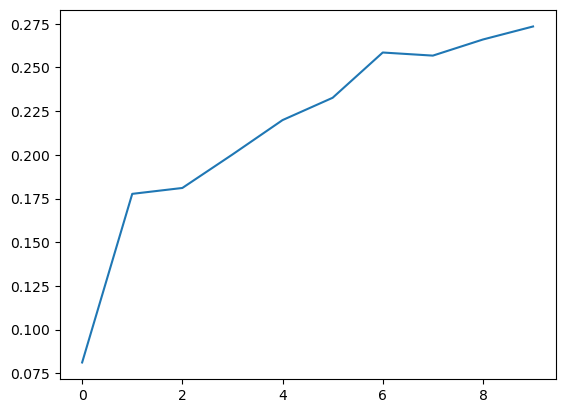

In [72]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])